In [1]:
import numpy as np
from sklearn.model_selection import train_test_split # 切分训练和测试集
from sklearn.metrics import accuracy_score # 计算准确率
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import fetch_openml
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
# 使用的python版本 3.9.6

# 1 获取MNIST数据集并划分测试集、训练集

In [2]:
# 获取MNIST数据集,并抽样部分
mnist = fetch_openml('mnist_784')
# mnist
idx = np.random.choice(70000,5000, replace=False)
X, Y = mnist.data.to_numpy(), mnist.target.to_numpy().astype('int')
X = X[idx]
Y = Y[idx]
print(X.shape, Y.shape)

(5000, 784) (5000,)


In [3]:
# 划分训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
# print(X_train, Y_train)
X_train

(4000, 784) (1000, 784) (4000,) (1000,)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
Y_train

array([1, 4, 4, ..., 2, 4, 4])

### 模型测试与评估（sklearn的knn分类器）

In [4]:
# sklearn
knn = KNeighborsClassifier(n_neighbors=3,algorithm='kd_tree')
# 训练
knn.fit(X_train,Y_train)
# 测试
Y_pred_sklearn = knn.predict(X_test)
# 评估模型
accuracy_sklearn = accuracy_score(Y_test,Y_pred_sklearn)
print(f'sklearn KNN Accuracy: {accuracy_sklearn*100:.2f}%')

sklearn KNN Accuracy: 91.20%


## 2 基于kd树实现knn算法

In [5]:
# 定义函数计算欧几里得距离
def euclidean_distance(x,y):
    return np.sqrt(np.sum((x - y) ** 2))

euclidean_distance(X[1],X[2])

2092.8411310942834

In [7]:
# kd树节点
class KDNode:
    def __init__(self, data=None, left_child=None, right_child=None):
        self.data = data
        self.left_child = left_child
        self.right_child = right_child                
        
# 构造kd树(划分数据集X)
def create_kd_tree(X,depth=0):
    if len(X) == 0:
        return None
    # k是数据的维度
    k = X.shape[1]
    # 根据深度选择划分维度
    axis = depth % k
    # 对数据排序
    X = X[X[:, axis].argsort()]
    # 获取中间点
    pos = X.shape[0]//2
    pos_node = X[pos]
    x1 = X[:pos]
    x2 = X[pos+1:]
    # print(x1,x2)
    # 递归构造kd树
    return KDNode(data = pos_node,left_child=create_kd_tree(x1,depth+1),right_child = create_kd_tree(x2,depth+1))

In [8]:
# 搜索KD树
def search_kd_tree(tree,target,k=3):
    if tree is None:
        return []
    # 存储遍历到的K个近邻节点的data
    K_nearest = []
    stack = [(tree,0)] # 存储待遍历节点Node的stack
    while stack:
        node, depth = stack.pop()
        if node is None:
            continue
        dist = euclidean_distance(target,node.data) # 计算节点与要分类的目标点的距离
        if len(K_nearest) < k: # K_nearest未装满时，装入节点
            K_nearest.append(node.data)
        else:# 当K_nearest装满时，比较目标点到当前节点的距离与目标点到K_nearset中的最远的节点的距离，小于则替换，大于等于不替换
            max_distance = 0
            max_pos = 0
            for i in range(k):
                if max_distance < euclidean_distance(K_nearest[i],target):
                    max_distance = euclidean_distance(K_nearest[i],target)
                    max_pos = i
            if dist < max_distance:
                K_nearest.pop(max_pos)
                K_nearest.append(node.data)  
        axis = depth % target.shape[0] # 计算深度对应的划分维度
        axis_diff = target[axis] - node.data[axis] # 计算该维度下，目标节点与当前节点的差
        if axis_diff <= 0: # 差小于等于0时，该节点左子树入栈，若K_nearset未装满或K_nearest中距目标点最远的点与目标点距离大于axis_diff的绝对值时，右子树也入栈
            if node.left_child is not None:
                stack.append((node.left_child,depth+1))
            if node.right_child is not None:
                if len(K_nearest) < k :
                    stack.append((node.right_child,depth+1))
                else:
                    flag = False
                    for i in range(k):
                        if abs(axis_diff) < euclidean_distance(K_nearest[i],target):
                            flag = True
                            break
                    if flag:
                        stack.append((node.right_child,depth+1))
        else: # 差大于0时，该节点右子树入栈，若K_nearset未装满或K_nearest中距目标点最远的点与目标点距离大于axis_diff的绝对值时，左子树也入栈
            if node.right_child is not None:
                stack.append((node.right_child,depth+1))
            if node.left_child is not None:
                if len(K_nearest) < k :
                    stack.append((node.left_child,depth+1))
                else:
                    flag = False
                    for i in range(k):
                        if abs(axis_diff) < euclidean_distance(K_nearest[i],target):
                            flag = True
                            break
                    if flag:
                        stack.append((node.left_child,depth+1))
        # return [data for data , _ in K_nearest] # 返回遍历完KD树后的K_nearest
        # print("k_nearest content:", K_nearest,depth)
    try:
        return [data for data in K_nearest]
    except TypeError: 
        print("k_nearest contains elements that cannot be unpacked:")
        for item in K_nearest:
            print(item)
        raise
    

### 使用自己构建的knn分类器，以k=3为参数训练模型并进行评估

In [9]:
# 构建kd树
kd_tree = create_kd_tree(X_train)

# 使用knn算法分类        
def knn_classifier(X_train,Y_train,X_test,k=3):
    Y_pred = []
    for test_point in X_test:
        K_nearest = search_kd_tree(kd_tree,test_point,k)
        labels = [Y_train[np.where((X_train == point.data).all(axis = 1))[0][0]] for point in K_nearest]
        counts = np.bincount(labels) # 计算K_nearest中样本最多的标签
        Y_pred.append(np.argmax(counts))
    return Y_pred

# 使用knn算法分类
k_neighbors = 3
Y_pred_kdtree = knn_classifier(X_train,Y_train,X_test,k_neighbors)

# 评估模型的性能
print('k = 3,kd_tree')
accuracy_kdtree = accuracy_score(Y_test,Y_pred_kdtree)
print(f'KNN Accuracy: {accuracy_kdtree*100:.2f}%')
classification_report_kdtree = classification_report(Y_test,Y_pred_kdtree,)
print(f'Classification Report:\n {classification_report_kdtree}')

k = 3,kd_tree
KNN Accuracy: 91.20%
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95       100
           1       0.86      0.99      0.92       112
           2       0.93      0.89      0.91        92
           3       0.89      0.93      0.91       108
           4       0.94      0.86      0.90       107
           5       0.97      0.84      0.90       109
           6       0.93      0.96      0.94        92
           7       0.93      0.91      0.92       104
           8       0.95      0.89      0.92        92
           9       0.82      0.86      0.84        84

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



结果分析：自己构建的knn分类器的准确率与sklearn的准确率一致，能够达到基本分类效果。

# 3 测试超参数k、p的最佳组合

## 调节p值，构建可输入不同k、p值的分类器

In [10]:
# 超参数p
# 1 默认 p=2 欧几里得距离
# 2 p=1 曼哈顿距离
def manhattan_distance(x,y):
    return np.sum(np.abs(x-y))
# 根据p值，采用计算距离的方式
def cal_distance_p(x,y,p=2):
    if p == 1:
        return manhattan_distance(x,y)
    elif p == 2:
        return euclidean_distance(x,y)
    
# 不同p值的搜索KD树函数
def search_kd_tree_p(tree,target,k=3,p=2):
    if tree is None:
        return []
    # 存储遍历到的K个近邻节点的data
    K_nearest = []
    stack = [(tree,0)] # 存储待遍历节点Node的stack
    while stack:
        node, depth = stack.pop()
        if node is None:
            continue
        dist = cal_distance_p(target,node.data,p) # 计算节点与要分类的目标点的距离
        if len(K_nearest) < k: # K_nearest未装满时，装入节点
            K_nearest.append(node.data)
        else:# 当K_nearest装满时，比较目标点到当前节点的距离与目标点到K_nearset中的最远的节点的距离，小于则替换，大于等于不替换
            max_distance = 0
            max_pos = 0
            for i in range(k):
                if max_distance < cal_distance_p(K_nearest[i],target,p):
                    max_distance = cal_distance_p(K_nearest[i],target,p)
                    max_pos = i
            if dist < max_distance:
                K_nearest.pop(max_pos)
                K_nearest.append(node.data)                 
        axis = depth % target.shape[0] # 计算深度对应的划分维度
        axis_diff = target[axis] - node.data[axis] # 计算该维度下，目标节点与当前节点的差
        if axis_diff <= 0: # 差小于等于0时，该节点左子树入栈，若K_nearset未装满或K_nearest中距目标点最远的点与目标点距离大于axis_diff的绝对值时，右子树也入栈
            if node.left_child is not None:
                stack.append((node.left_child,depth+1))
            if node.right_child is not None:
                if len(K_nearest) < k :
                    stack.append((node.right_child,depth+1))
                else:
                    flag = False
                    for i in range(k):
                        if abs(axis_diff) < cal_distance_p(K_nearest[i],target,p):
                            flag = True
                            break
                    if flag:
                        stack.append((node.right_child,depth+1))
        else: # 差大于0时，该节点右子树入栈，若K_nearset未装满或K_nearest中距目标点最远的点与目标点距离大于axis_diff的绝对值时，左子树也入栈
            if node.right_child is not None:
                stack.append((node.right_child,depth+1))
            if node.left_child is not None:
                if len(K_nearest) < k :
                    stack.append((node.left_child,depth+1))
                else:
                    flag = False
                    for i in range(k):
                        if abs(axis_diff) < cal_distance_p(K_nearest[i],target,p):
                            flag = True
                            break
                    if flag:
                        stack.append((node.left_child,depth+1))
        # return [data for data , _ in K_nearest] # 返回遍历完KD树后的K_nearest
        # print("k_nearest content:", K_nearest,depth)
    try:
        return [data for data in K_nearest]
    except TypeError: 
        print("k_nearest contains elements that cannot be unpacked:")
        for item in K_nearest:
            print(item)
        raise

# 不同p值、k值的knn分类器
def knn_classifier_params_test(X_train,Y_train,X_test,k=3,p=2):
    Y_pred = []
    for test_point in X_test:
        K_nearest = search_kd_tree_p(kd_tree,test_point,k,p)
        labels = [Y_train[np.where((X_train == point.data).all(axis = 1))[0][0]] for point in K_nearest]
        counts = np.bincount(labels) # 计算K_nearest中样本最多的标签
        Y_pred.append(np.argmax(counts))
    return Y_pred


## 测试k、p最佳组合

p=1,k=1,accuracy =92.40%
p=1,k=2,accuracy =89.70%
p=1,k=3,accuracy =91.50%
p=1,k=4,accuracy =91.60%
p=1,k=5,accuracy =92.20%
p=1,k=6,accuracy =91.70%
p=1,k=7,accuracy =91.30%
p=1,k=8,accuracy =90.40%
p=1,k=9,accuracy =90.60%
p=1,k=10,accuracy =89.90%
p=2,k=1,accuracy =93.10%
p=2,k=2,accuracy =91.80%
p=2,k=3,accuracy =92.70%
p=2,k=4,accuracy =92.70%
p=2,k=5,accuracy =93.20%
p=2,k=6,accuracy =92.30%
p=2,k=7,accuracy =92.30%
p=2,k=8,accuracy =92.10%
p=2,k=9,accuracy =91.30%
p=2,k=10,accuracy =91.20%
best params: p = 2,k = 5,accuracy= 93.20%


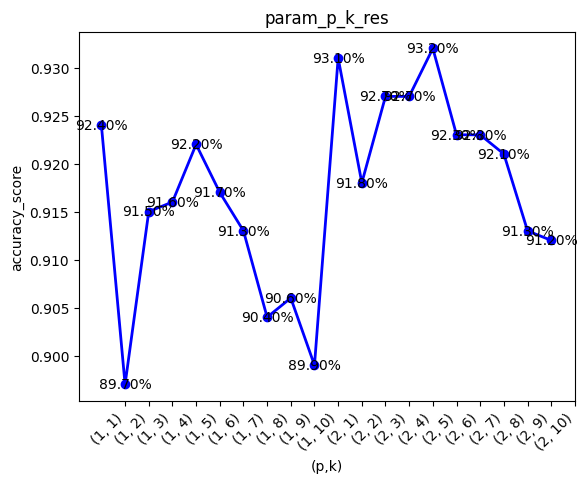

<Figure size 1800x600 with 0 Axes>

In [11]:
# 测试超参数p，k组合
kd_tree = create_kd_tree(X_train)
def test_param_p_k(p_start,p_end,k_start,k_end,X_train,Y_train,X_test):
    best_param_k = k_start
    best_param_p = p_start
    best_score = 0
    param_list = []
    accuracy_list = []
    for i in range(p_start,p_end+1):
        for j in range(k_start,k_end+1):
            param_list.append((i,j))
            y_pred = knn_classifier_params_test(X_train,Y_train,X_test,j,i)
            ij_score = accuracy_score(Y_test,y_pred)
            print(f'p={i},k={j},accuracy ={ij_score*100:.2f}%')
            accuracy_list.append(ij_score)
            if ij_score > best_score:
                best_score = ij_score
                best_param_p = i
                best_param_k = j
    param_str = [str(i) for i in param_list]
    param_list_x = list(range(1,21))
    plt.plot(param_str,accuracy_list,color = 'blue',linestyle = '-',marker = 'o',linewidth = 2)
    for i,j in zip(range(len(param_str)),accuracy_list):
        plt.text(i,j,f'{j*100:.2f}%',ha='center',va='center')
    plt.xticks(param_list_x,param_str,rotation = 45,ha = "right")
    plt.title('param_p_k_res')
    plt.xlabel('(p,k)')
    plt.ylabel('accuracy_score')
    plt.figure(figsize = (18,6))
    plt.savefig('accuracy_score_search_param_p_k.png')
    return best_param_p,best_param_k, best_score

best_param_p,best_param_k,best_score = test_param_p_k(1,2,1,10,X_train,Y_train,X_test)
print(f'best params: p = {best_param_p},k = {best_param_k},accuracy= {best_score*100:.2f}%')

结果记录:

第一次实验最佳参数：p=2,k=1

第二次实验最佳参数：p=2,k=3

第三次实验最佳参数：p=2,k=5

第四次实验最佳参数：p=2.k=5


# 4 优化kd树

## 尝试复现k-NNMC论文

In [45]:
# 使用k-NNMC分类
kd_tree = create_kd_tree(X_train)
def knn_mean_classifier(X_train,Y_train,X_test,k=3):
    Y_pred = []
    for test_point in X_test:
        K_nearest = search_kd_tree(kd_tree,test_point,k)
        # 获取对应的标签值
        labels = [Y_train[np.where((X_train == point.data).all(axis = 1))[0][0]] for point in K_nearest]
        # 计算每种类别对应的所有数据的均值
        K_nearest_mean = {}
        for xi,label in zip(K_nearest,labels):
            if label in K_nearest_mean:
                K_nearest_mean[label] = xi+K_nearest_mean[label]
            else:
                K_nearest_mean[label] = xi
        # 获取距离目标点最近的数据对应的类别
        min_dist = euclidean_distance(list(K_nearest_mean.values())[0],test_point)
        min_label = list(K_nearest_mean.keys())[0]
        for key,value in K_nearest_mean.items():
            dist_i = euclidean_distance(value,test_point)
            if dist_i < min_dist:
                min_dist = dist_i
                min_label = key
        Y_pred.append(min_label)
    return Y_pred

# 使用knn算法分类
k_neighbors = 3
Y_pred_knnmc = knn_mean_classifier(X_train,Y_train,X_test,k_neighbors)
# 对K个数据进行加权平均
# 评估模型的性能
print('k = 3,knn_mean_tree')
accuracy_knnmc = accuracy_score(Y_test,Y_pred_knnmc)
print(f'KNN Accuracy knn_mean_tree: {accuracy_knnmc*100:.2f}%')

k = 3,knn_mean_tree
KNN Accuracy knn_mean_tree: 86.70%


<Figure size 1000x600 with 0 Axes>

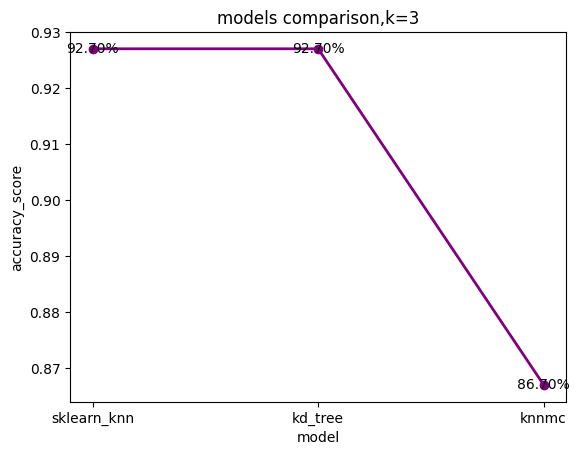

<Figure size 1000x600 with 0 Axes>

In [46]:
# 几种模型对比
model_list = ['sklearn_knn','kd_tree','knnmc']
model_accuracy_list = [accuracy_sklearn,accuracy_kdtree,accuracy_knnmc]
plt.plot(model_list,model_accuracy_list,color = 'purple',linestyle = '-',marker = 'o',linewidth = 2)
for i,j in zip(model_list,model_accuracy_list):
    plt.text(i,j,f'{j*100:.2f}%',ha='center',va='center')
plt.title('models comparison,k=3')
param_list_x = list(range(1,4))
plt.xlabel('model')
plt.ylabel('accuracy_score')
plt.figure(figsize = (10,6))

## 尝试使用wk-NNC优化

In [11]:
# 尝试使用wk-NNC优化

# 选择复现论文的权值计算方式
def cal_weight(dist_1,dist_k,dist_i):
    weight = (dist_k-dist_i)/(dist_k-dist_1)
    return weight
kd_tree = create_kd_tree(X_train)

# 计算k个节点的距离、同时返回k个近邻中最大和最小距离
def cal_dist(K_nearest,target):
    dist_array = []
    dist_1 =  cal_distance_p(K_nearest[0],target,2)
    dist_k =  dist_1
    for point in K_nearest:
        dist_i = cal_distance_p(point,target,2)
        dist_array.append(dist_i)
        if dist_i < dist_1:
            dist_1 = dist_i
        if dist_i > dist_k:
            dist_k = dist_i
    return dist_array,dist_1,dist_k

# 使用knn算法分类        
def weighted_knn_classifier(X_train,Y_train,X_test,k=3):
    Y_pred = []
    for test_point in X_test:
        K_nearest = search_kd_tree(kd_tree,test_point,k)
        K_nearest_dist,dist_1,dist_k = cal_dist(K_nearest,test_point)
        K_nearest_weight = []
        label_weight_sum = {}
        labels = [Y_train[np.where((X_train == point.data).all(axis = 1))[0][0]] for point in K_nearest]
        # 计算每个节点的权重
        for i in range(0,len(K_nearest_dist)):
            weight_i = cal_weight(dist_1,dist_k,K_nearest_dist[i])
            K_nearest_weight.append(weight_i)
        # 每个类别的权重由这一类的节点权重和得到
        for label,weight in zip(labels,K_nearest_weight):
            if label in label_weight_sum:
                label_weight_sum[label] += weight
            else:
                label_weight_sum[label] = weight
        # 获取权值最大的类别
        max_label = max(label_weight_sum,key = label_weight_sum.get)
        Y_pred.append(max_label)
    return Y_pred

# 使用knn算法分类
k_neighbors = 7
Y_pred_kdtree = weighted_knn_classifier(X_train,Y_train,X_test,k_neighbors)
# 评估模型的性能
print('k = 7,weighted_kd_tree')
accuracy_weighted_kdtree = accuracy_score(Y_test,Y_pred_kdtree)
print(f'KNN Accuracy weighted_kd_tree: {accuracy_weighted_kdtree*100:.2f}%')


k = 7,weighted_kd_tree
KNN Accuracy weighted_kd_tree: 92.50%


In [12]:
# 构建kd树,k=7
kd_tree = create_kd_tree(X_train)

# 使用knn算法分类
k_neighbors = 7
Y_pred_kdtree = knn_classifier(X_train,Y_train,X_test,k_neighbors)

# 评估模型的性能
print('k = 7,kd_tree')
accuracy_kdtree = accuracy_score(Y_test,Y_pred_kdtree)
print(f'KNN Accuracy: {accuracy_kdtree*100:.2f}%')

k = 7,kd_tree
KNN Accuracy: 91.50%


In [13]:
# sklearn
knn = KNeighborsClassifier(n_neighbors=7,algorithm='kd_tree')
# 训练
knn.fit(X_train,Y_train)
# 测试
Y_pred_sklearn = knn.predict(X_test)
# 评估模型
accuracy_sklearn = accuracy_score(Y_test,Y_pred_sklearn)
print(f'sklearn KNN Accuracy k=7: {accuracy_sklearn*100:.2f}%')

sklearn KNN Accuracy k=7: 91.50%


<Figure size 1000x600 with 0 Axes>

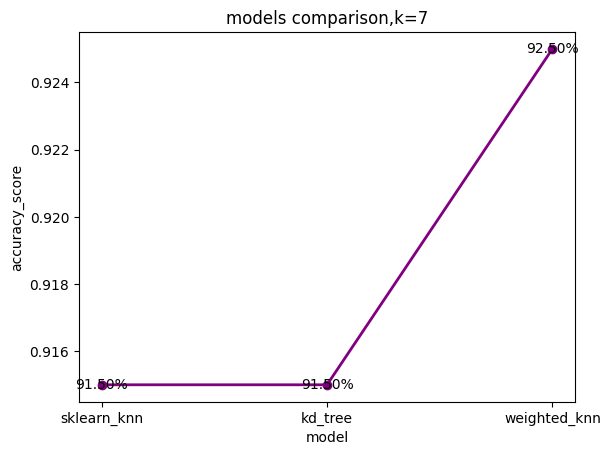

<Figure size 1000x600 with 0 Axes>

In [14]:
# 几种模型对比
model_list = ['sklearn_knn','kd_tree','weighted_knn']
model_accuracy_list = [accuracy_sklearn,accuracy_kdtree,accuracy_weighted_kdtree]
plt.plot(model_list,model_accuracy_list,color = 'purple',linestyle = '-',marker = 'o',linewidth = 2)
for i,j in zip(model_list,model_accuracy_list):
    plt.text(i,j,f'{j*100:.2f}%',ha='center',va='center')
plt.title('models comparison,k=7')
plt.xlabel('model')
plt.ylabel('accuracy_score')
plt.figure(figsize = (10,6))